# Testing CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from numpy import random

%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


Load trained networks into pytorch CNN acrhitecture. Note, the architecture that was used for training must be imported here.

In [32]:
from CNN_architectures import StreaksCNN

file_net = 'test'

net = StreaksCNN(winSz = 48, filtSz = 5, convPad = 2)
net.load_state_dict(torch.load('networks/%s.pytorch' % file_net))
net.to(device)
net.eval()

StreaksCNN(
  (cnn_part): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.2)
  (fc1): Linear(in_features=1152, out_feat

Load data and preprocess

[ 5.63321425 51.7162811 ] [16.05931858  0.65271444]


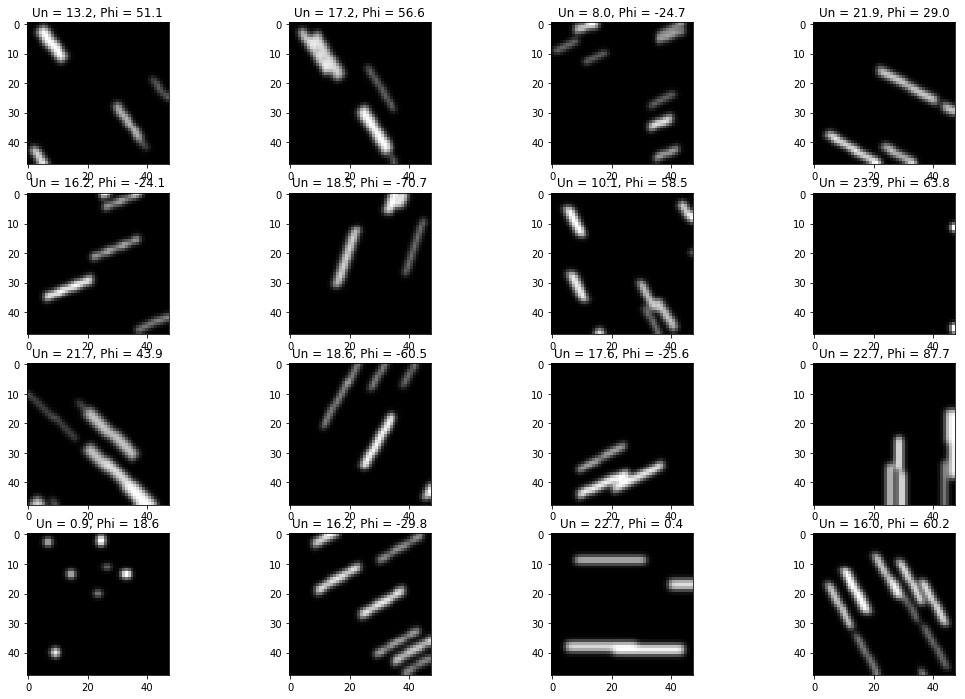

In [33]:
h5f = h5py.File(('networks/%s_data.h5' % file_net), 'r')

testImages = np.array(h5f['validationImages'], dtype = np.float32)
testData = np.array(h5f['validationData'], dtype = np.float32)
scale = np.array(h5f['scale'])
mean = np.array(h5f['mean'])
windowSize = h5f['windowSize']
h5f.close()

print(scale, mean)

indices = random.randint(0, len(testImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (testData[indices[i],0], testData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Preprocess data

((4800, 2), (4800, 2))


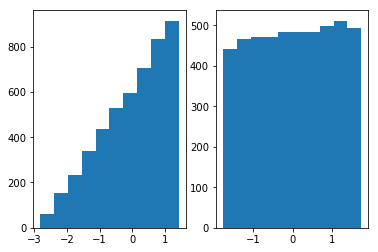

In [35]:
testImages /= 255

scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

testData = scaler.transform(testData)
#testData[:,0] = (testData[:,0] - mean[0])/scale[0]
#testData[:,1] = (testData[:,1] - mean[1])/scale[1]

print((testData.shape, testData.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(testData[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(testData[:,1]);

## Apply CNN

Apply final network to the validation data set and check accuracy on Un and phi independently

In [37]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

xtest = torch.from_numpy(testImages)
ytest = torch.from_numpy(testData)

test_dataset = TensorDataset(xtest, ytest)
test_loader = DataLoader(test_dataset, **params)

ypredicted = np.empty(shape=(0,2))

for inputs, outputs in test_loader:
    # Wrap tensors in Variables
    inputs, outputs = inputs.to(device), outputs.to(device)
            
    # Forward pass
    val_outputs = net(inputs)
    
    ypredicted = np.concatenate((ypredicted, val_outputs.data.numpy()))
    
ypredicted = scaler.inverse_transform(ypredicted)
ytruth = scaler.inverse_transform(testData)
yresiduals = ypredicted - ytruth
yrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))

print('RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1])

thrNorm = 1;
thrPhi = 18; 
numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)

accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)
print(accuracy)

RMSE on Un =  5.779236211911967 , RMSE on phi =  52.91822214809093
[0.10395833 0.20395833]
